<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/VAE_with_latent_subspaces_cell_cycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/PMBio/scLVM/blob/master/tutorials/tcell_demo.ipynb

Variational Autoencoder Model (VAE) with latent subspaces based on:
https://arxiv.org/pdf/1812.06190.pdf

In [0]:
#Step 1: import dependencies
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('dark_background')

import pandas as pd

In [0]:
# import os
# from matplotlib import cm
# import h5py
# import scipy as SP
# import pylab as PL

--------
--------

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE69405


In [0]:
df1 = pd.read_csv("GSE69405_PROCESSED_GENE_TPM_ALL.txt",delimiter="\t")

In [0]:
df2 = pd.read_csv('geneset.txt', delimiter='\t')

In [0]:
geneset_ids = df2['KEGG_CELL_CYCLE'].values  #http://software.broadinstitute.org/gsea/msigdb/cards/KEGG_CELL_CYCLE
gene_ids = df1['gene_name'].values

In [0]:
list_a = []
for i in geneset_ids:
  a = np.asarray(np.argwhere(gene_ids == i))
  list_a.append(a)

In [0]:
flat_list = []
for sublist in list_a:
    for item in sublist:
        flat_list.append(item)
        
flat_list = np.squeeze(np.array(flat_list))

cell_cycle_ids = flat_list

In [0]:
X_H358 = df1.loc[:, df1.columns.str.startswith('H358_SC')].values
X_LC_MBT = df1.loc[:, df1.columns.str.startswith('LC-MBT-15_SC')].values
X_LC_PT = df1.loc[:, df1.columns.str.startswith('LC-PT-45_SC')].values
X_LC_PT_Re = df1.loc[:, df1.columns.str.startswith('LC-PT-45-Re_SC')].values

In [63]:
print(X_H358.shape, X_LC_MBT.shape, X_LC_PT.shape, X_LC_PT_Re.shape)

(57820, 50) (57820, 49) (57820, 34) (57820, 43)


In [0]:
Y_0 = 0*np.ones(X_H358.shape[1])
Y_1= 1*np.ones(X_LC_MBT.shape[1])
Y_2 = 2*np.ones(X_LC_PT.shape[1])
Y_3 = 3*np.ones(X_LC_PT_Re.shape[1])

In [0]:
Y = np.concatenate([Y_0, Y_1, Y_2, Y_3], axis=0)

Remove cell cycle genes

In [66]:
X = np.concatenate([X_H358, X_LC_MBT, X_LC_PT, X_LC_PT_Re], axis=-1)
X = X.T
U = X[:, cell_cycle_ids]
X = np.delete(X, cell_cycle_ids, axis=-1)
print(X.shape)
print(U.shape)
print(Y.shape)


(176, 57695)
(176, 125)
(176,)


-----
-----

In [67]:
mean = np.mean(X, axis=0)
variance = np.var(X, axis=0)

indx_small_mean = np.argwhere(mean < 0.0001)
X = np.delete(X, indx_small_mean, axis=1)

mean = np.mean(X, axis=0)
variance = np.var(X, axis=0)
print(X.shape)

(176, 29835)


In [68]:
mean = np.mean(X, axis=0)
variance = np.var(X, axis=0)

fano = mean/variance

indx_small_fano = np.argwhere(fano < 2.0)
X = np.delete(X, indx_small_fano, axis=1)

print(X.shape)

(176, 1102)


In [0]:
X = np.log(1+X)
U = np.log(1+U)

In [0]:
X = np.delete(X, 72, axis=0)

In [0]:
Y = np.delete(Y, 72, axis=0)

In [0]:
U = np.delete(U, 72, axis=0)

In [89]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd.fit(U.T)  


print(svd.explained_variance_ratio_)  

print(svd.explained_variance_ratio_.sum())  

print(svd.singular_values_)  

U_ = svd.components_

U_ = U_.T

[0.61523034 0.05539576]
0.6706261035616871
[460.40373994  74.31895691]


In [87]:
U.shape

(176, 125)

In [0]:
#Reconstruction loss
def x_given_w_z(w, z, output_size, training_phase, reg):
  with tf.variable_scope('M/x_given_w_z'):
    act = tf.nn.leaky_relu
    
    h = tf.concat((w,z), axis=-1)
    h = tf.layers.dense(h, 8, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 16, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 128, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
    loc = tf.layers.dense(h, output_size)
    #log_variance = tf.layers.dense(x, latent_size)
    #scale = tf.nn.softplus(log_variance)
    scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)


#KL term for w
def w_given_x_y(x, y, latent_size, training_phase, reg): #+
  with tf.variable_scope('M/w_given_x_y'):
    act = tf.nn.leaky_relu
    h = tf.concat((x,y), axis=-1)
    
    h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 128, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 16, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 8, act, kernel_regularizer=reg)
    
    loc = tf.layers.dense(h,latent_size)
    log_variance = tf.layers.dense(h, latent_size)
    scale = tf.nn.softplus(log_variance)
    #scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

def w_given_y(y, y_size, training_phase, reg):
  with tf.variable_scope('M/w_given_y'):
    act = tf.nn.leaky_relu
    h = y
    
    h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 128, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 16, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 8, act, kernel_regularizer=reg)
    
    loc = tf.layers.dense(h, y_size)
    log_variance = tf.layers.dense(h, y_size)
    scale = tf.nn.softplus(log_variance)
    return tfd.MultivariateNormalDiag(loc, scale)


#KL term for z
def z_given_x(x, latent_size, training_phase, reg): #+
  with tf.variable_scope('M/z_given_x'):
    act = tf.nn.leaky_relu
    h = x
    
    h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 128, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 16, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 8, act, kernel_regularizer=reg)
    
    loc = tf.layers.dense(h,latent_size)
    log_variance = tf.layers.dense(h, latent_size)
    scale = tf.nn.softplus(log_variance)
#     scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

def z_given(latent_size):
  with tf.variable_scope('M/z_given'):
    loc = tf.zeros(latent_size)
    scale = 0.1*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)


#For the Mutual information term
def y_given_z(z, y_size, training_phase, reg, reuse=None):
  with tf.variable_scope('N', reuse=reuse):
    act = tf.nn.leaky_relu
    h = z
    
    h = tf.layers.dense(h, 8, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 16, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 128, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
    
    
    loc = tf.layers.dense(h, y_size)
    log_variance = tf.layers.dense(h, y_size)
    scale = tf.nn.softplus(log_variance)
    #scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

In [0]:
#Connect encoder and decoder and define the loss function
tf.reset_default_graph()

x_in = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_in')
x_out = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_out')
u_in = tf.placeholder(tf.float32, shape=[None, 1], name='u_in')
training_phase = tf.placeholder(tf.bool, None, name='training_phase')
reg = regularizers.l1_l2(l1=0.0, l2=0.000000001)

beta = np.array([20.0, 0.0001, 0.001, 0.1, 1.0])
#beta= np.array([100000.0, 1.0, 0.02, 10.0, 1.0])

z_latent_size = 2
w_latent_size = 2

M_learning_rate = 5e-4
N_learning_rate = 5e-4

#KL_w
wIy = w_given_y(u_in, w_latent_size, training_phase, reg)
wIxy = w_given_x_y(x_in, u_in, w_latent_size, training_phase, reg)
wIxy_sample = wIxy.sample()
wIxy_mean = wIxy.mean()
kl_w = tf.reduce_mean(wIxy.log_prob(wIxy_sample)- wIy.log_prob(wIxy_sample))
#kl_w = tf.reduce_mean(tfd.kl_divergence(wIxy, wIy)) #analytical
C_w = tf.placeholder(tf.float32, name='C_w')

#KL_z
zI = z_given(z_latent_size)
zIx = z_given_x(x_in, z_latent_size, training_phase, reg)
zIx_sample = zIx.sample()
zIx_mean = zIx.mean()
kl_z = tf.reduce_mean(zIx.log_prob(zIx_sample)- zI.log_prob(zIx_sample))
#kl_z = tf.reduce_mean(tfd.kl_divergence(zIx, zI)) #analytical
C_z = tf.placeholder(tf.float32, name='C_z')

#Reconstruction
xIwz = x_given_w_z(wIxy_sample, zIx_sample, X.shape[1], training_phase, reg)
rec_out = xIwz.mean()
rec_loss = tf.losses.mean_squared_error(x_out, rec_out)

M1 = beta[0]*rec_loss + beta[1]*kl_w + beta[2]*kl_z

yIz = y_given_z(zIx_sample, U.shape[1], training_phase, reg, reuse=False)
ent2 = -tf.reduce_mean(yIz.entropy())
M2 = beta[3]*ent2

M_reg = tf.losses.get_regularization_loss(scope='M/')

M_cost = M1 + M2 + M_reg

M_optimizer = tf.train.AdamOptimizer(M_learning_rate)

M_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='M/')
M_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='M/')

with tf.control_dependencies(M_update_ops):
  M_train = M_optimizer.minimize(M_cost, var_list=M_train_vars,
                                       name='train_M')

  
yIz_N = y_given_z(zIx_sample, U.shape[1], training_phase, reg, reuse=True)
logN = tf.reduce_mean(-yIz_N.log_prob(u_in))
N = beta[4]*logN

N_reg = tf.losses.get_regularization_loss(scope='N')

N_cost = N + N_reg



N_optimizer = tf.train.AdamOptimizer(N_learning_rate)

N_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='N')
N_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='N')

with tf.control_dependencies(N_update_ops):
  N_train = N_optimizer.minimize(N_cost, var_list=N_train_vars,
                                       name='train_N')

# Saver to save session for reuse
saver = tf.train.Saver()

In [0]:
#Helper function
def batch_generator(features, x, u, batch_size):
  """Function to create python generator to shuffle and split features into batches along the first dimension."""
  idx = np.arange(features.shape[0])
  np.random.shuffle(idx)
  for start_idx in range(0, features.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, features.shape[0])
    part = idx[start_idx:end_idx]
    yield features[part,:], x[part,:] , u[part, :]

In [131]:
U_.shape

(175, 2)

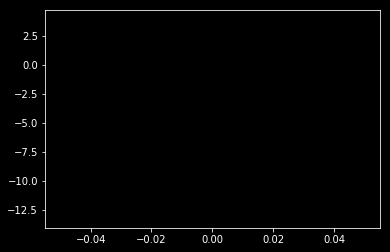

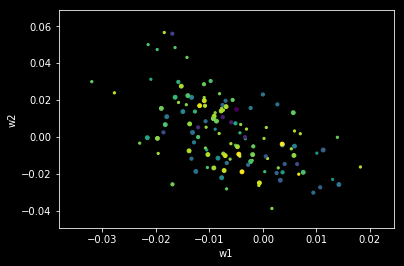

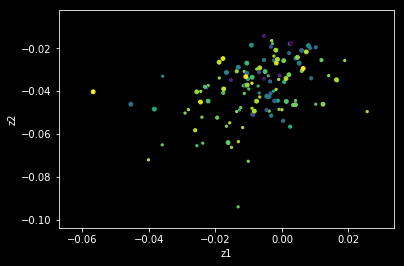

epoch: 1, M_loss: -6.5, M1_loss: 0.0, M2_loss: -6.6, N_loss: 35.07
epoch: 1, rec_loss: 0.00116, kl_w: -0.00, kl_z: 19.16


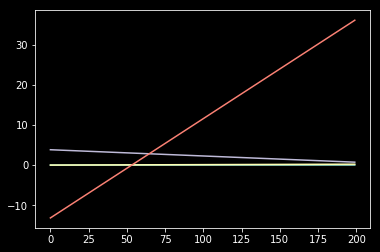

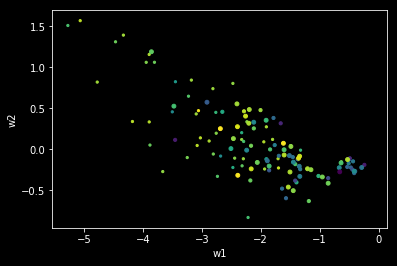

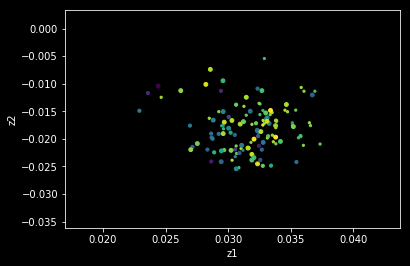

epoch: 200, M_loss: 18.1, M1_loss: 0.0, M2_loss: 18.1, N_loss: -182.86
epoch: 200, rec_loss: 0.00071, kl_w: 1.13, kl_z: 3.64


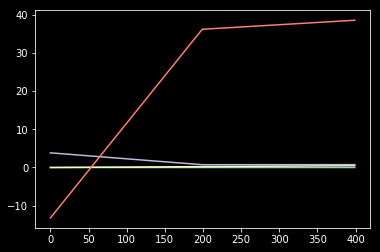

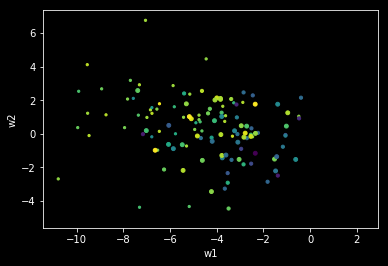

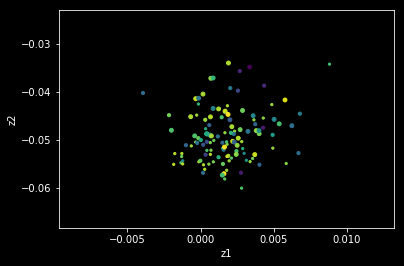

epoch: 400, M_loss: 19.3, M1_loss: 0.0, M2_loss: 19.3, N_loss: -192.59
epoch: 400, rec_loss: 0.00063, kl_w: 2.40, kl_z: 3.75


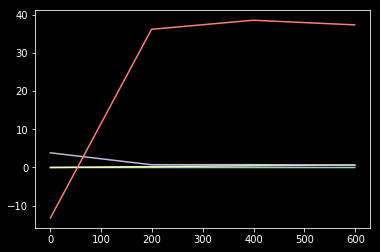

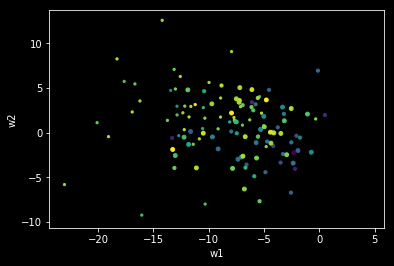

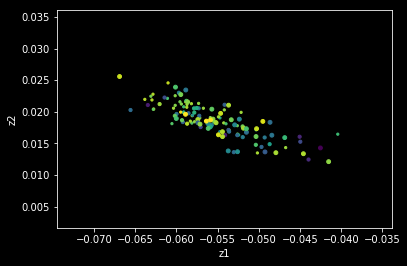

epoch: 600, M_loss: 18.7, M1_loss: 0.0, M2_loss: 18.6, N_loss: -187.95
epoch: 600, rec_loss: 0.00054, kl_w: 3.17, kl_z: 3.16


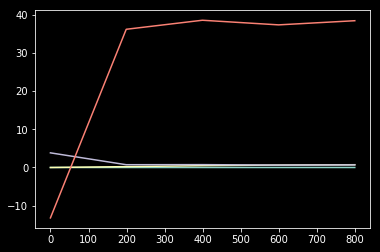

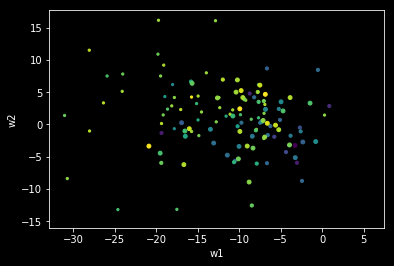

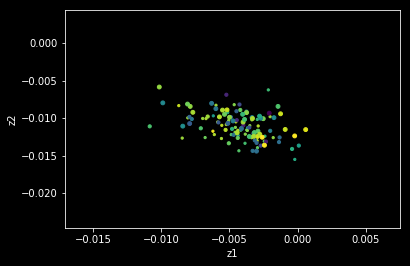

epoch: 800, M_loss: 19.2, M1_loss: 0.0, M2_loss: 19.2, N_loss: -192.45
epoch: 800, rec_loss: 0.00048, kl_w: 3.64, kl_z: 3.39


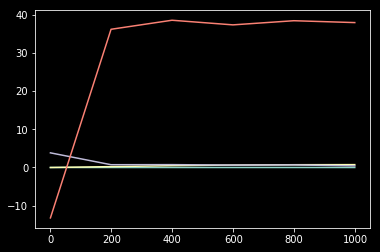

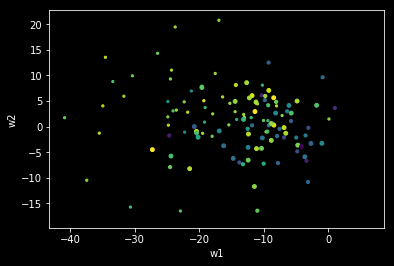

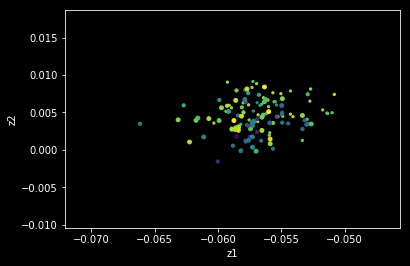

epoch: 1000, M_loss: 19.0, M1_loss: 0.0, M2_loss: 18.9, N_loss: -188.72
epoch: 1000, rec_loss: 0.00044, kl_w: 3.76, kl_z: 2.12


KeyboardInterrupt: ignored

In [132]:
n_epochs = 15000
batch_size = X.shape[0]
start = time.time()
rec_out_plt = []
kl_w_plt= []
kl_z_plt = []
epoch_plt = []
M2_plt = []
N_loss_plt = []
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  
  for i in range(n_epochs):
    C_w_ = 20.0+100.0*(1-i/(n_epochs-1))
    C_z_ = 20.0+100.0*(1-i/(n_epochs-1))
    gen = batch_generator(X, X, U_[:,0][:,np.newaxis], batch_size) #create batch generator
    M_loss = 0
    N_loss = 0
    rec_loss_ = 0
    kl_w_ = 0
    kl_z_ = 0
    M1_ = 0
    M2_ = 0
    ent2_ = 0
    logN_ = 0
    
    for j in range(np.int(X.shape[0]/batch_size)):
      x_in_batch, x_out_batch, u_batch = gen.__next__()
      
      
      _, M_loss_, rec_loss__, kl_w__, kl_z__, M1__, ent2__, M2__= sess.run([M_train, M_cost, rec_loss, kl_w, kl_z, M1, ent2, M2], feed_dict={x_in: x_in_batch, x_out: x_out_batch, u_in: u_batch, training_phase:True, C_w:C_w_, C_z:C_z_})
      M_loss += M_loss_
      rec_loss_ += rec_loss__
      kl_w_ += kl_w__
      kl_z_ += kl_z__
      M1_ += M1__
      M2_ += M2__
      
      _, N_loss_, logN__= sess.run([N_train, N_cost, logN], feed_dict={x_in: x_in_batch, x_out: x_out_batch, u_in: u_batch, training_phase:True, C_w:C_w_, C_z:C_z_})
      N_loss += N_loss_
      logN_ += logN__
      
      
    if (i+1)% 200 == 0 or i == 0:
      wIxy_mean_, zIx_mean_, rec_out_= sess.run([wIxy_mean, zIx_mean, rec_out], feed_dict ={x_in:X, x_out:X, u_in:U_[:,0][:,np.newaxis], training_phase:False})
      rec_out_plt.append(rec_loss_)
      kl_w_plt.append(kl_w_/10.0)
      kl_z_plt.append(kl_z_/10.0)
      M2_plt.append(M2_/1.0)
      N_loss_plt.append(N_loss)
      epoch_plt.append(i)
      
      plt.figure(1) 
      plt.plot(epoch_plt[-10:], rec_out_plt[-10:])
      plt.plot(epoch_plt[-10:], kl_w_plt[-10:])
      plt.plot(epoch_plt[-10:], kl_z_plt[-10:])
      plt.plot(epoch_plt[-10:], M2_plt[-10:])
      
      plt.figure(2)
      plt.scatter(wIxy_mean_[:,0],wIxy_mean_[:,1], c=U_[:,0], s=5*Y, cmap='viridis');
      plt.xlabel('w1');
      plt.ylabel('w2');
      
      plt.figure(3)
      plt.scatter(zIx_mean_[:,0],zIx_mean_[:,1], c=U_[:,0], s=5*Y, cmap='viridis');
      plt.xlabel('z1');
      plt.ylabel('z2');
      plt.show()
      
      end = time.time()
      print('epoch: {0}, M_loss: {1:.1f}, M1_loss: {2:.1f}, M2_loss: {3:.1f}, N_loss: {4:.2f}'.format((i+1), M_loss/(1+np.int(X.shape[0]/batch_size)), M1_/(1+np.int(X.shape[0]/batch_size)), M2_/(1+np.int(X.shape[0]/batch_size)), N_loss_/(1+np.int(X.shape[0]/batch_size))))
      print('epoch: {0}, rec_loss: {1:.5f}, kl_w: {2:.2f}, kl_z: {3:.2f}'.format((i+1), rec_loss_/(1+np.int(X.shape[0]/batch_size)), kl_w_/(1+np.int(X.shape[0]/batch_size)), kl_z_/(1+np.int(X.shape[0]/batch_size))))
      start = time.time()

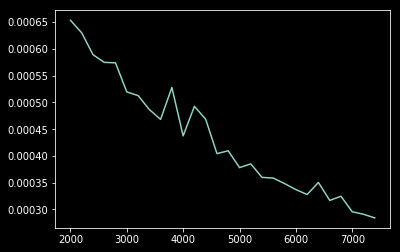

In [109]:
plt.plot(epoch_plt[10:], rec_out_plt[10:])

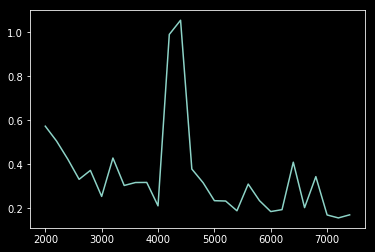

In [110]:
plt.plot(epoch_plt[10:], kl_w_plt[10:])

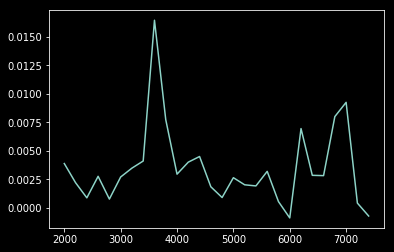

In [111]:
plt.plot(epoch_plt[10:], kl_z_plt[10:])

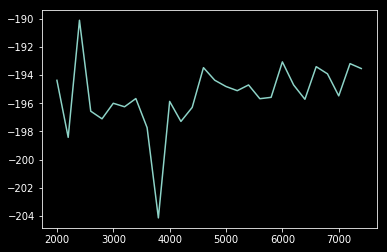

In [112]:
plt.plot(epoch_plt[10:], M2_plt[10:])

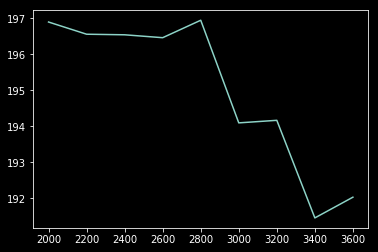

In [105]:
plt.plot(epoch_plt[10:], N_loss_plt[10:])

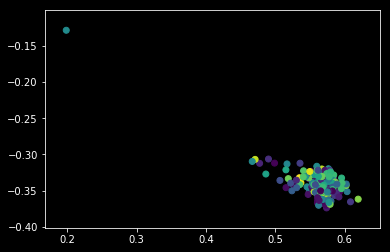

In [74]:
plt.scatter(zIx_mean_[:,0],zIx_mean_[:,1], c=U[:,0], cmap='viridis');

In [75]:
np.argwhere(zIx_mean_[:,0]<0.3)

array([[72]])

In [29]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd.fit(U.T)  


print(svd.explained_variance_ratio_)  

print(svd.explained_variance_ratio_.sum())  

print(svd.singular_values_)  

U_ = svd.components_

U_ = U_.T

[0.61529567 0.05529166]
0.6705873283573539
[461.66978867  74.43846079]


In [30]:
U_.shape

(176, 2)

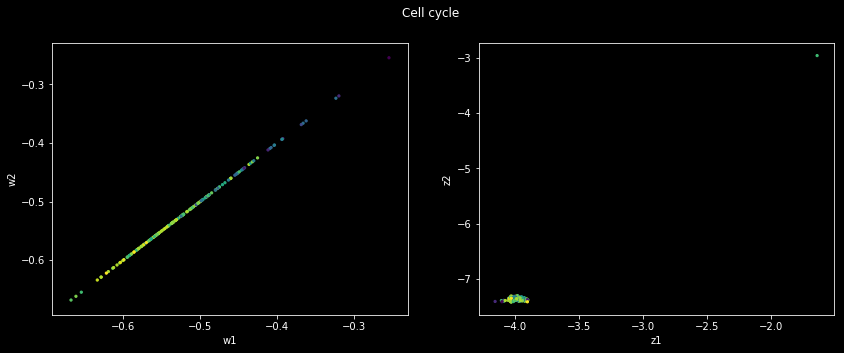

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))
axs[0].scatter(wIxy_mean_[:,0],wIxy_mean_[:,0], c=U_[:,0], cmap='viridis', s=5.0);
axs[0].set_xlabel('w1')
axs[0].set_ylabel('w2')

axs[1].scatter(zIx_mean_[:,0],zIx_mean_[:,1], c=U_[:,0], cmap='viridis', s=5.0);
axs[1].set_xlabel('z1')
axs[1].set_ylabel('z2')

fig.suptitle('Cell cycle')
plt.show()

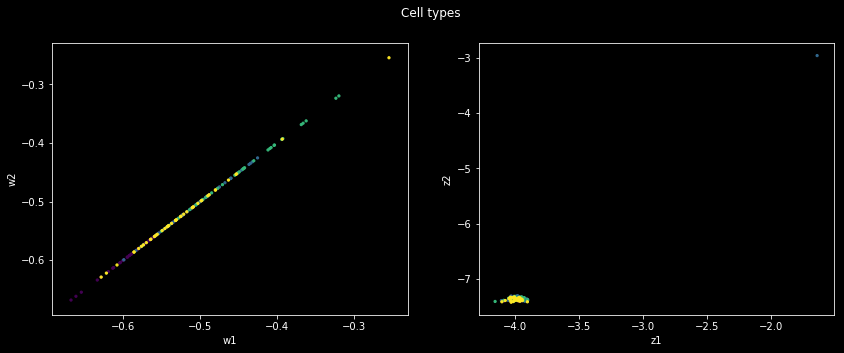

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))
axs[0].scatter(wIxy_mean_[:,0],wIxy_mean_[:,0], c=Y, cmap='viridis', s=5.0);
axs[0].set_xlabel('w1')
axs[0].set_ylabel('w2')

axs[1].scatter(zIx_mean_[:,0],zIx_mean_[:,1], c=Y, cmap='viridis', s=5.0);
axs[1].set_xlabel('z1')
axs[1].set_ylabel('z2')

fig.suptitle('Cell types')
plt.show()

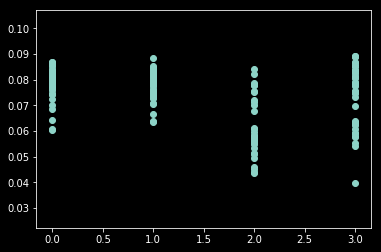

In [169]:
plt.scatter(Y, U_[:,0])

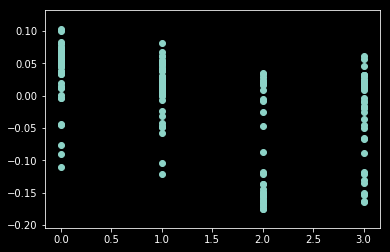

In [443]:
plt.scatter(Y, U_[:,1])

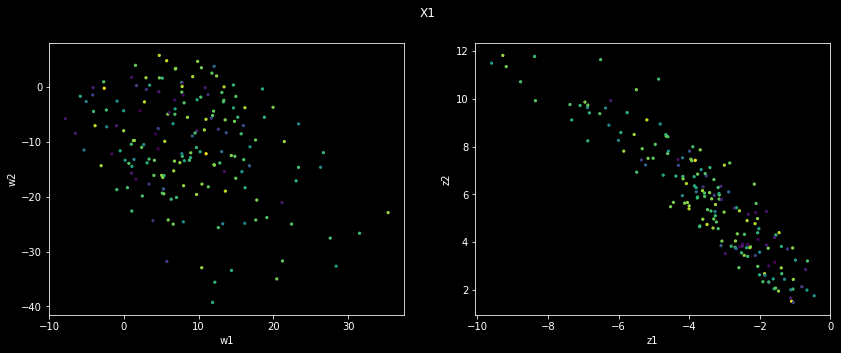

In [271]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))
axs[0].scatter(wIxy_mean_[:,0],wIxy_mean_[:,1], c=U_[:,1], cmap='viridis', s=5.0);
axs[0].set_xlabel('w1')
axs[0].set_ylabel('w2')

axs[1].scatter(zIx_mean_[:,0],zIx_mean_[:,1], c=U_[:,1], cmap='viridis', s=5.0);
axs[1].set_xlabel('z1')
axs[1].set_ylabel('z2')

fig.suptitle('X1')
plt.show()

In [0]:
error = np.abs(X-rec_out_)

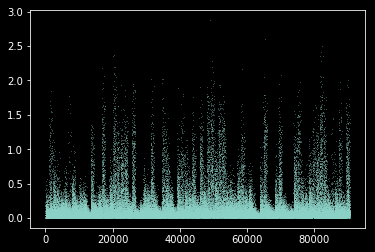

In [0]:
plt.plot(np.reshape(error, -1), '*', markersize=0.1);

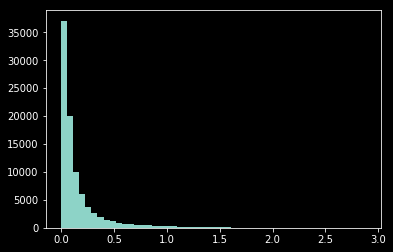

In [0]:
plt.hist(np.reshape(error, -1), bins=50);

Simple VAE

In [0]:
X = np.concatenate((X, U), axis=-1)

In [0]:
#Reconstruction loss
def x_given_z(z, output_size, training_phase, reg):
  with tf.variable_scope('M/x_given_w_z'):
    act = tf.nn.leaky_relu
    
    h = z
    h = tf.layers.dense(h, 8, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 16, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 128, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
    loc = tf.layers.dense(h, output_size)
    #log_variance = tf.layers.dense(x, latent_size)
    #scale = tf.nn.softplus(log_variance)
    scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)


#KL term for w
def z_given_x(x, latent_size, training_phase, reg): #+
  with tf.variable_scope('M/w_given_x_y'):
    act = tf.nn.leaky_relu
    h = x
    
    h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 128, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 16, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 8, act, kernel_regularizer=reg)
    
    loc = tf.layers.dense(h,latent_size)
    log_variance = tf.layers.dense(h, latent_size)
    scale = tf.nn.softplus(log_variance)
    #scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

def z_given(latent_size):
  with tf.variable_scope('M/z_given'):
    loc = tf.zeros(latent_size)
    scale = 0.1*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

In [0]:
#Connect encoder and decoder and define the loss function
tf.reset_default_graph()

x_in = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_in')
x_out = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_out')
u_in = tf.placeholder(tf.float32, shape=[None, 125], name='u_in')
training_phase = tf.placeholder(tf.bool, None, name='training_phase')
reg = regularizers.l1_l2(l1=0.0, l2=0.00000001)


z_latent_size = 2

M_learning_rate = 5e-4
N_learning_rate = 5e-4

zIx = z_given_x(x_in, z_latent_size, training_phase, reg)
zIx_sample = zIx.sample()
zIx_mean = zIx.mean()
zI = z_given(z_latent_size)
kl_z = tf.reduce_mean(zIx.log_prob(zIx_sample)- zI.log_prob(zIx_sample))
#Reconstruction
xIz = x_given_z(zIx_sample, X.shape[1], training_phase, reg)
rec_out = xIz.mean()
rec_loss = tf.losses.mean_squared_error(x_out, rec_out)

reg1 = tf.losses.get_regularization_loss()

M_cost = rec_loss+0.0000001*kl_z+reg1

M_optimizer = tf.train.AdamOptimizer(M_learning_rate)

M_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='M/')
M_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='M/')

with tf.control_dependencies(M_update_ops):
  M_train = M_optimizer.minimize(M_cost, var_list=M_train_vars,
                                       name='train_M')


In [0]:
#Helper function
def batch_generator(features, x, u, batch_size):
  """Function to create python generator to shuffle and split features into batches along the first dimension."""
  idx = np.arange(features.shape[0])
  np.random.shuffle(idx)
  for start_idx in range(0, features.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, features.shape[0])
    part = idx[start_idx:end_idx]
    yield features[part,:], x[part,:] , u[part, :]

In [250]:
n_epochs = 10000
batch_size = X.shape[0]
start = time.time()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  
  for i in range(n_epochs):
    gen = batch_generator(X, X, U, batch_size) #create batch generator
    M_loss = 0
    rec_loss_ = 0
    kl_z_ = 0
    
    for j in range(np.int(X.shape[0]/batch_size)):
      x_in_batch, x_out_batch, u_batch = gen.__next__()
      
      
      _, M_loss_, rec_loss__, kl_z__= sess.run([M_train, M_cost, rec_loss, kl_z], feed_dict={x_in: x_in_batch, x_out: x_out_batch, u_in: u_batch, training_phase:True})
      M_loss += M_loss_
      rec_loss_ += rec_loss__
      kl_z_ += kl_z__
      
    if (i+1)% 50 == 0 or i == 0:
      zIx_mean_, rec_out_= sess.run([zIx_mean, rec_out], feed_dict ={x_in:X, x_out:X, u_in:U, training_phase:False})
      end = time.time()
      print('epoch: {0}, M_loss: {1:.1f}, M1_loss: {2:.1f}, M2_loss: {3:.1f}, N_loss: {4:.2f}'.format((i+1), M_loss/(1+np.int(X.shape[0]/batch_size)), M1_/(1+np.int(X.shape[0]/batch_size)), M2_/(1+np.int(X.shape[0]/batch_size)), N_loss_/(1+np.int(X.shape[0]/batch_size))))
      print('epoch: {0}, rec_loss: {1:.5f}, kl_w: {2:.2f}, kl_z: {3:.2f}'.format((i+1), rec_loss_/(1+np.int(X.shape[0]/batch_size)), kl_w_/(1+np.int(X.shape[0]/batch_size)), kl_z_/(1+np.int(X.shape[0]/batch_size))))
      start = time.time()

epoch: 1, M_loss: 0.6, M1_loss: 0.0, M2_loss: 0.1, N_loss: 0.98
epoch: 1, rec_loss: 0.58303, kl_w: 6.85, kl_z: 21.98
epoch: 50, M_loss: 0.1, M1_loss: 0.0, M2_loss: 0.1, N_loss: 0.98
epoch: 50, rec_loss: 0.09133, kl_w: 6.85, kl_z: 9816.76
epoch: 100, M_loss: 0.1, M1_loss: 0.0, M2_loss: 0.1, N_loss: 0.98
epoch: 100, rec_loss: 0.08972, kl_w: 6.85, kl_z: 8418.32
epoch: 150, M_loss: 0.1, M1_loss: 0.0, M2_loss: 0.1, N_loss: 0.98
epoch: 150, rec_loss: 0.08963, kl_w: 6.85, kl_z: 7106.04
epoch: 200, M_loss: 0.1, M1_loss: 0.0, M2_loss: 0.1, N_loss: 0.98
epoch: 200, rec_loss: 0.08958, kl_w: 6.85, kl_z: 5941.70
epoch: 250, M_loss: 0.1, M1_loss: 0.0, M2_loss: 0.1, N_loss: 0.98
epoch: 250, rec_loss: 0.08954, kl_w: 6.85, kl_z: 4989.97
epoch: 300, M_loss: 0.1, M1_loss: 0.0, M2_loss: 0.1, N_loss: 0.98
epoch: 300, rec_loss: 0.08950, kl_w: 6.85, kl_z: 4264.72
epoch: 350, M_loss: 0.1, M1_loss: 0.0, M2_loss: 0.1, N_loss: 0.98
epoch: 350, rec_loss: 0.08945, kl_w: 6.85, kl_z: 3664.93
epoch: 400, M_loss: 0.1,

In [251]:
U_.shape

(176, 2)

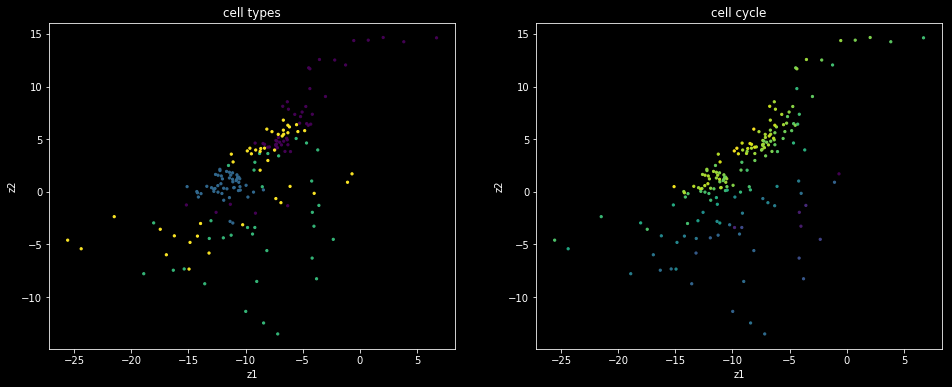

In [252]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(zIx_mean_[:,0],zIx_mean_[:,1], c=Y, cmap='viridis', s=5.0);
axs[0].set_xlabel('z1')
axs[0].set_ylabel('z2')
axs[0].set_title('cell types')

axs[1].scatter(zIx_mean_[:,0],zIx_mean_[:,1], c=U_[:,0], cmap='viridis', s=5.0);
axs[1].set_xlabel('z1')
axs[1].set_ylabel('z2')
axs[1].set_title('cell cycle')

plt.show()